## Введение 

### Главные вопросы: 
- Какие навыки прокачивать начинающему специалисту?
- На какую зарплату расчитывать начинающему специалисту?

### Задачи: 
- Проанализировать данные датасета на корректность(null значения, отклонения, странные значения в колонках)
- Сформировать топ навыков для всех специалистов
- Посмотреть распределение вакансий для специалистов с опытом / без
- Посмотреть распределение вилок з/п для специалистов с опытом / без


# Первичный анализ датасета 

## Загружаем данные / портируем библиотеки 

In [3]:
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
# Set the path to the file you'd like to load
file_path = "vacancies.csv"

# Load the latest version
df = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  "antonbelyaevd/headhunter-vacancies-for-data-search",
  file_path,
  # Provide any additional arguments like 
  # sql_query or pandas_kwargs. See the 
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

## Анализируем любые 5 записей

In [4]:
df.sample(5)

,name,tags,link,experience,lower_salary,upper_salary,currency
453,Системный аналитик DWH,"['Базы данных', 'Анализ данных', 'Greenplum', ...",https://saratov.hh.ru/vacancy/85855721?from=va...,Требуемый опыт работы: 3–6 лет,NaN,NaN,NaN
634,Менеджер по интернет-маркетингу,['Английский\xa0— C1 — Продвинутый'],https://saratov.hh.ru/vacancy/85244609?from=va...,Требуемый опыт работы: 1–3 года,NaN,NaN,NaN
280,Data analyst,"['SQL;', 'Python']",https://saratov.hh.ru/vacancy/83770923?from=va...,Требуемый опыт работы: 1–3 года,NaN,NaN,NaN
647,Systems Analyst,"['SQL', 'Постановка задач разработчикам', 'Сис...",https://saratov.hh.ru/vacancy/84928395?from=va...,Требуемый опыт работы: 1–3 года,200000.0,200000.0,₽
267,Дата инженер \ Data Engineer AI (удаленно),"['SQL', 'Python', 'Java', 'Android', 'Kotlin',...",https://saratov.hh.ru/vacancy/85038244?from=va...,Требуемый опыт работы: 3–6 лет,220000.0,340000.0,₽


## Проанализируем датасет: 

- name - название вакансий (все значения должны быть строчными)
- tags - навыки нужные для вакансии (должны быть непустыми строками с реальным стеком технологий)
- link - ссылка на вакансию (должно быть строкой)
- experience - требуемый опыт работы (строка с реальным опытом работы (без опыта, 1-3 года, 3-6 лет))
- lower_salary - нижняя вилка з/п (должно быть значение float или int или же null, просто потому что часто в вакансиях не указывают вилку з/п)
- upper_salary - верхняя вилка з/п (должно быть значение float или int или же null, просто потому что часто в вакансиях не указывают вилку з/п)
- currency - курс валюты по которой считается з/п (в нашем случае символ, может быть null)

## Смотрим колонки в датасете 

In [5]:
df.name

0                           Ведущий менеджер по продажам
1                        Data Scientist (команда Поиска)
2                       Data Scientist в b2c направление
3      Портфельный риск-аналитик / Middle Data Scient...
4                                        Трафик-менеджер
                             ...                        
795                               BI Developer (Tableau)
796                               Performance-маркетолог
797                               Ведущий специалист RPA
798                        IT Специалист/ Engineer (RPA)
799                           Архитектор направления CVM
Name: name, Length: 800, dtype: object

In [6]:
df.info() # null значений очень много в некоторых колонках lower_salary, upper_salary, это можно обосновать тем, что часто в вакансиях не пишут з/п

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   name          797 non-null    object 
 1   tags          800 non-null    object 
 2   link          800 non-null    object 
 3   experience    797 non-null    object 
 4   lower_salary  187 non-null    float64
 5   upper_salary  187 non-null    float64
 6   currency      160 non-null    object 
dtypes: float64(2), object(5)
memory usage: 43.9+ KB


## Вывидим дубликаты, если они есть

In [7]:
num_duplicates = df.duplicated().sum() # выводим количество дубликатов 
print(f"Количество дубликатов: {num_duplicates}")

Количество дубликатов: 0


## Смотрим уникальное количество типов валюты 

In [36]:
df.currency.unique()

array(['₽', nan, '$', '€'], dtype=object)

## Анализируем числовые показатели 

In [37]:
df.describe()

,lower_salary,upper_salary
count,187.000000,187.000000
mean,134893.550802,166982.855615
std,117371.793825,153270.633569
min,1.000000,1.000000
25%,40000.000000,42500.000000
50%,120000.000000,150000.000000
75%,200000.000000,250000.000000
max,556080.000000,1000000.000000


## Переводим валюты в рубли для построения графиков 

In [38]:
usd_mark_dollar = df['currency'] == '$'
usd_mark_euro = df['currency'] == '€'

df.loc[usd_mark_dollar, 'upper_salary'] = df.loc[usd_mark_dollar, 'upper_salary'] * 80 
df.loc[usd_mark_dollar, 'lower_salary'] = df.loc[usd_mark_dollar, 'lower_salary'] * 80

df.loc[usd_mark_euro, 'upper_salary'] = df.loc[usd_mark_euro, 'upper_salary'] * 93 
df.loc[usd_mark_euro, 'lower_salary'] = df.loc[usd_mark_euro, 'lower_salary'] * 93 

df.loc[usd_mark_dollar | usd_mark_euro, 'currency'] = '₽'

## Выведим уникальный список опыта для вакансий 

In [44]:
df.experience.unique()

array(['Требуемый опыт работы: не требуется',
       'Требуемый опыт работы: 3–6 лет',
       'Требуемый опыт работы: 1–3 года',
       'Требуемый опыт работы: более 6 лет', nan], dtype=object)

## Формируем топ навыков по всем вакансиям  из словаря 

In [40]:
total_skills_df = pd.DataFrame(dictionary_popular.items(), columns=['skill', 'count'])

total_skills_df = total_skills_df.sort_values('count', ascending=False).reset_index(drop=True)


total_skills_df.head(10)

,skill,count
0,SQL,219
1,Python,214
2,PostgreSQL,67
3,Big Data,55
4,Английский язык,52
5,Анализ данных,52
6,Hadoop,51
7,Java,50
8,Linux,49
9,ETL,47


## Посмотрим распределение навыков для вакансий без опыта

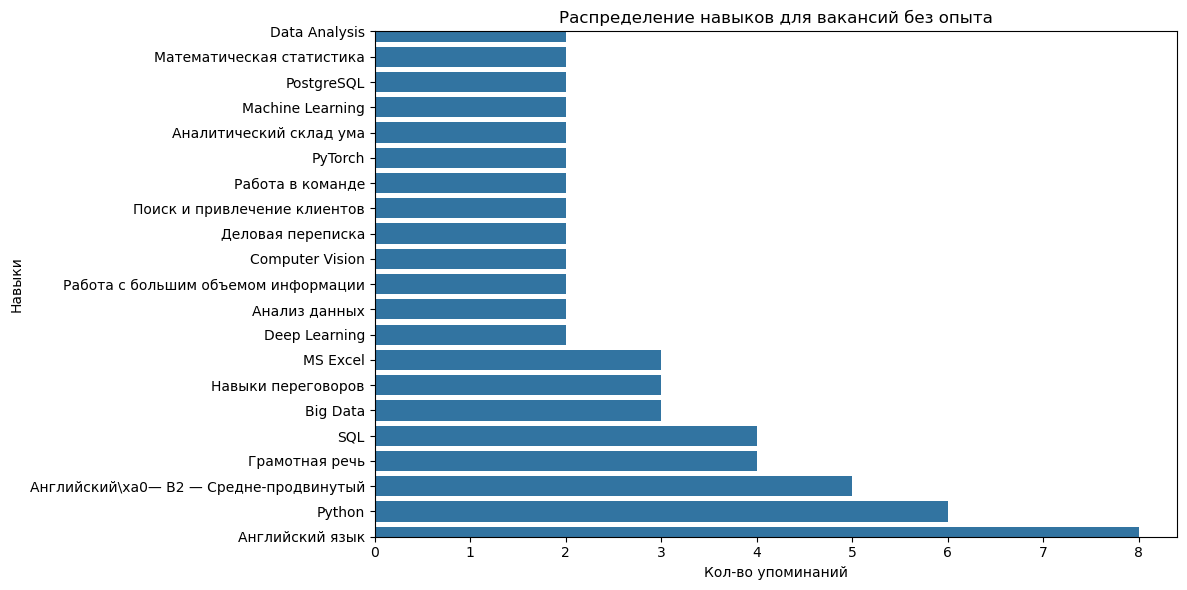

In [43]:
skills = {}

for skills_choice in df['tags'][df['experience'] == 'Требуемый опыт работы: не требуется']:
        skills_choice = skills_choice.strip('[]')
        items = skills_choice.split(',')
        items = [item.strip() for item in items]
        items = [item.strip('\'') for item in items]
        for skill in items: 
                if skill in skills:
                    skills[skill] += 1
                else:
                    skills[skill] = 1

skills_df = pd.DataFrame.from_dict(skills, orient='index', columns=['count'])
skills_df = skills_df.sort_values(by='count', ascending=False)
skills_df = skills_df[skills_df.index != '']

plt.figure(figsize=(12, 6)) 
sns.barplot(x=skills_df['count'], y=skills_df.index)
plt.xlabel('Кол-во упоминаний')
plt.ylabel('Навыки')
plt.title('Распределение навыков для вакансий без опыта')
plt.tight_layout()

plt.ylim(0, 20)
plt.show()

## Логический вывод из графика

Видно, что самыми популярными навыками для вакансий без опыта являются: английский, грамотная речь, python, sql, Big Data. Следовательно, можно сделать вывод, что при подготовке к собеседованию по вакансиям представленым в датасете лучше всего обращать внимание на эти навыки.

## Посмотрим медианую нижнюю вилку з/п для специалистов без опыта

In [46]:
median_lower_salary = df.loc[df['experience'] == 'Требуемый опыт работы: не требуется'].lower_salary.median()

print(median_lower_salary)

60000.0


## Посмотрим модальную нижнюю вилку з/п для специалистов без опыта

In [48]:
median_lower_salary = df.loc[df['experience'] == 'Требуемый опыт работы: не требуется'].lower_salary.mode()

print(median_lower_salary)

0    55000.0
1    60000.0
Name: lower_salary, dtype: float64


## Посмотрим медианную верхнюю вилку з/п для специалистов без опыта

In [47]:
median_upper_salary = df.loc[df['experience'] == 'Требуемый опыт работы: не требуется'].upper_salary.median()

print(median_upper_salary)

75000.0


## Посмотрим модальную верхнюю вилку з/п для специалистов без опыта

In [49]:
median_upper_salary = df.loc[df['experience'] == 'Требуемый опыт работы: не требуется'].upper_salary.mode()

print(median_upper_salary)

0    55000.0
Name: upper_salary, dtype: float64


## Распределение нижней вилки з/п по возрастанию (от меньшего к большему)

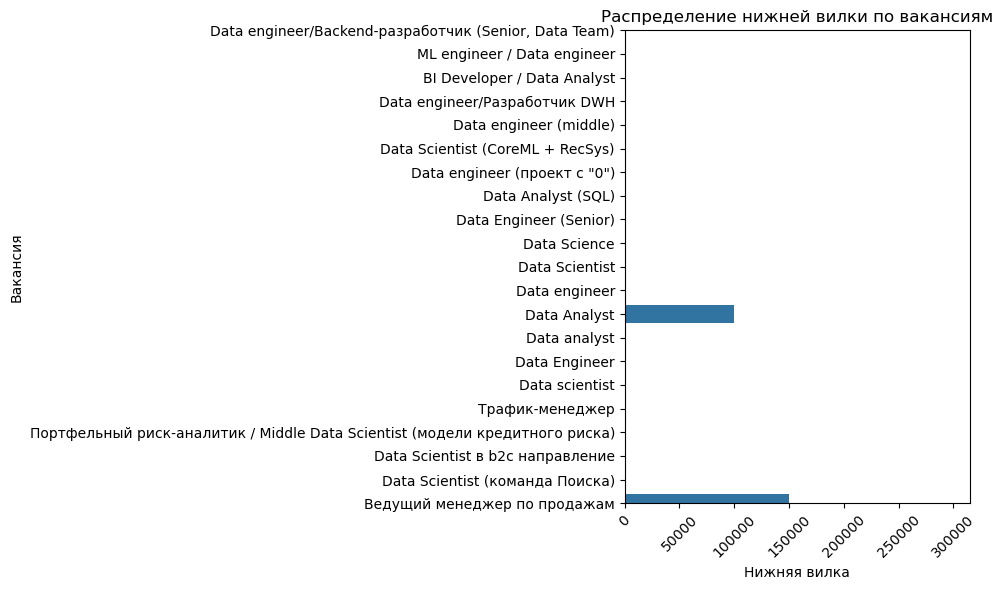

In [82]:
df_sorted = df.sort_values('lower_salary')

plt.figure(figsize=(12, 6)) 
sns.barplot(x=df_sorted.loc[df['experience'] == 'Требуемый опыт работы: не требуется']['lower_salary'], y=df_sorted['name'])
plt.xlabel('Нижняя вилка')
plt.xticks(rotation=45)
plt.ylabel('Вакансия')
plt.title('Распределение нижней вилки по вакансиям')
plt.tight_layout()

plt.ylim(0, 20)
plt.show()

## Вывод о распределении нижней вилки

Исходя из графика можно сделать вид, что есть много позиций где нижняя вилка не указана.

## Распределение верхней вилки з/п по возрастанию (от меньшего к большему)

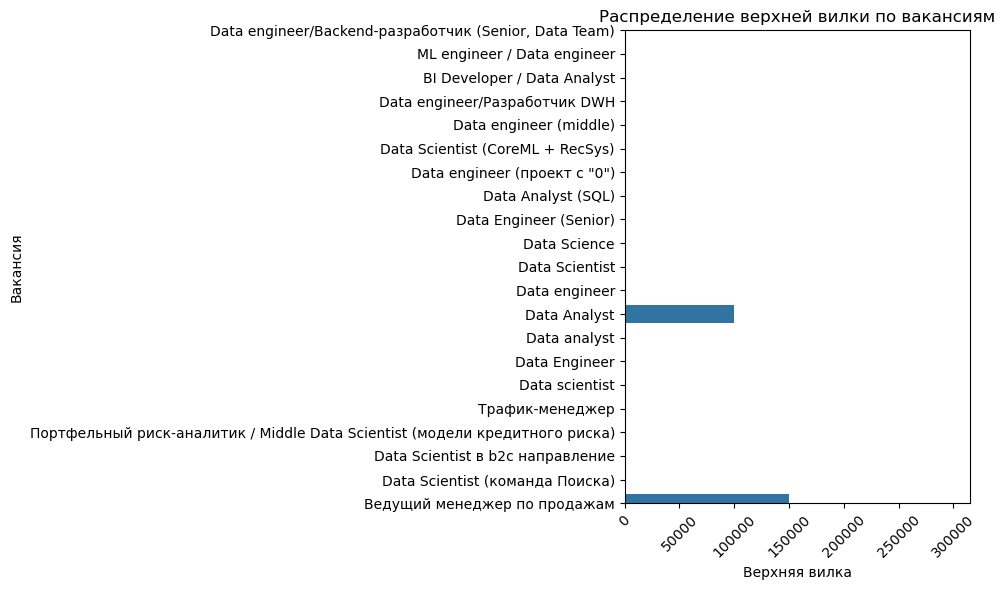

In [88]:
df_sorted = df.sort_values('upper_salary')

plt.figure(figsize=(12, 6)) 
sns.barplot(x=df_sorted.loc[df['experience'] == 'Требуемый опыт работы: не требуется']['upper_salary'], y=df_sorted['name'])
plt.xlabel('Верхняя вилка')
plt.xticks(rotation=45)
plt.ylabel('Вакансия')
plt.title('Распределение верхней вилки по вакансиям')
plt.tight_layout()

plt.ylim(0, 20)
plt.show()

## Вывод о распределении верхней вилки

Исходя из графика можно сделать вид, что есть много позиций где нижняя вилка не указана. А также то, что разпределение нижней вилки очень сильно похоже на распределение верхней.

## Количество вакансий взависимости от опыта 

In [62]:
df['кол-во вакансий взависимости от опыта'] = df.groupby('experience')['experience'].transform('count')

In [64]:
df.head(5)

,name,tags,link,experience,lower_salary,upper_salary,currency,кол-во вакансий взависимости от опыта
0,Ведущий менеджер по продажам,"['Активные продажи', 'Ведение переговоров', 'Т...",https://adsrv.hh.ru/click?b=533104&c=7&place=3...,Требуемый опыт работы: не требуется,150000.0,150000.0,₽,42.0
1,Data Scientist (команда Поиска),"['Python', 'PyTorch', 'SQL', 'Machine Learning...",https://saratov.hh.ru/vacancy/83116089?from=va...,Требуемый опыт работы: 3–6 лет,350000.0,350000.0,₽,390.0
2,Data Scientist в b2c направление,"['Python', 'Machine Learning', 'SQL', 'PyTorch...",https://saratov.hh.ru/vacancy/84009554?from=va...,Требуемый опыт работы: 3–6 лет,NaN,NaN,NaN,390.0
3,Портфельный риск-аналитик / Middle Data Scient...,[],https://saratov.hh.ru/vacancy/82421077?from=va...,Требуемый опыт работы: 3–6 лет,NaN,NaN,NaN,390.0
4,Трафик-менеджер,"['Анализ трафика', 'Аналитика', 'Маркетинг', '...",https://saratov.hh.ru/vacancy/84386152?from=va...,Требуемый опыт работы: 3–6 лет,110000.0,140000.0,₽,390.0


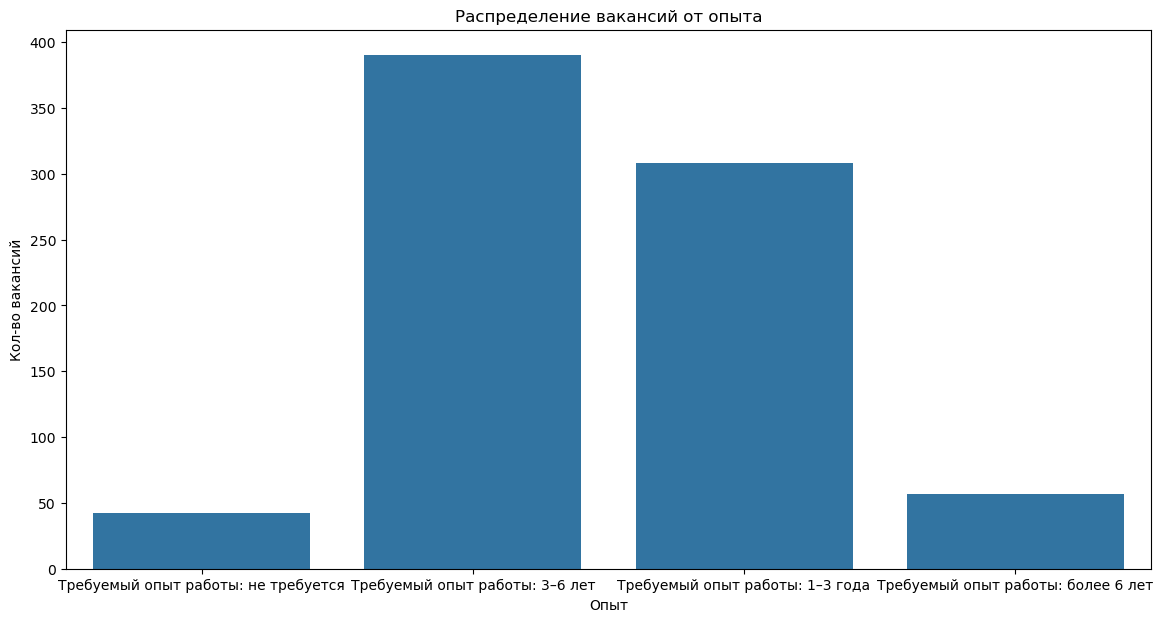

In [66]:
plt.figure(figsize=(14, 7))
sns.barplot(x=df.experience, y=df['кол-во вакансий взависимости от опыта'])

plt.xlabel('Опыт')
plt.ylabel('Кол-во вакансий')
plt.title('Распределение вакансий от опыта')

plt.show()

## Распределение нижней границы запрплаты по опыту

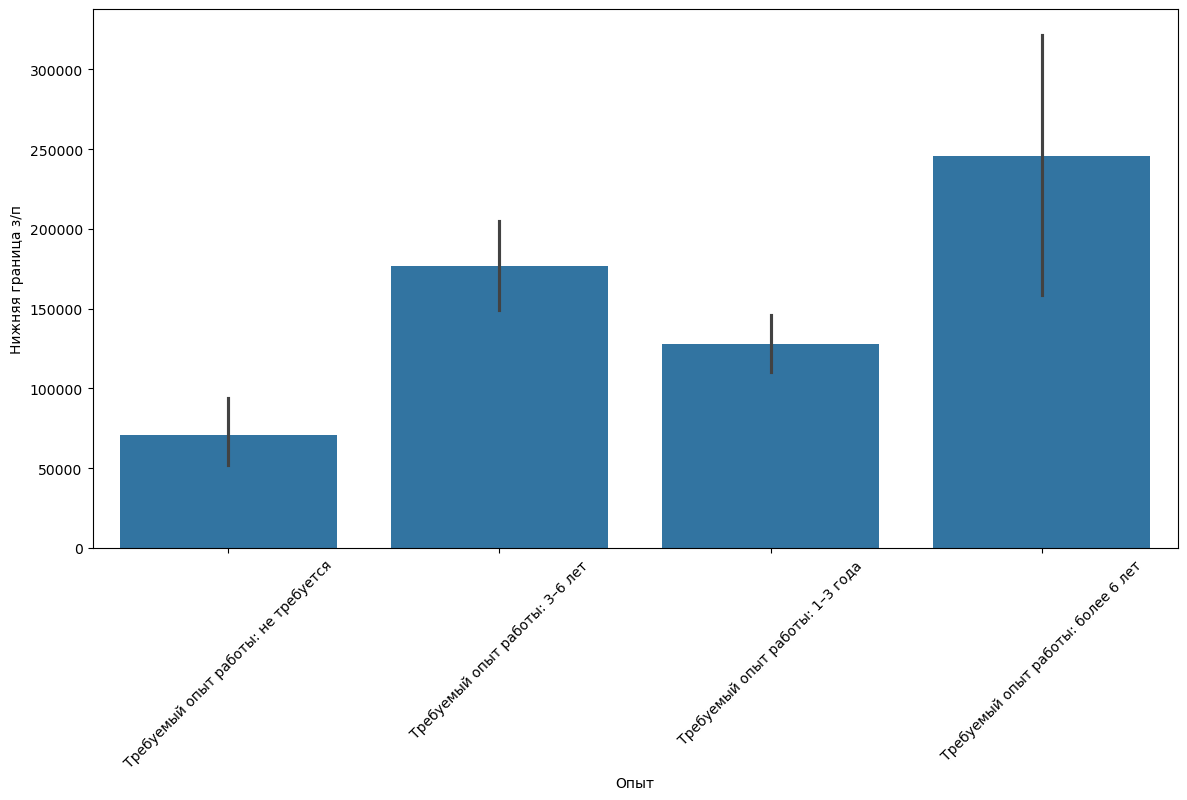

In [67]:
plt.figure(figsize=(14, 7))
sns.barplot(x=df['experience'], y=df['lower_salary'])
plt.xticks(rotation=45)

plt.xlabel('Опыт')
plt.ylabel('Нижняя граница з/п')
plt.show()

## Распределение верхней границы запрплаты по опыту

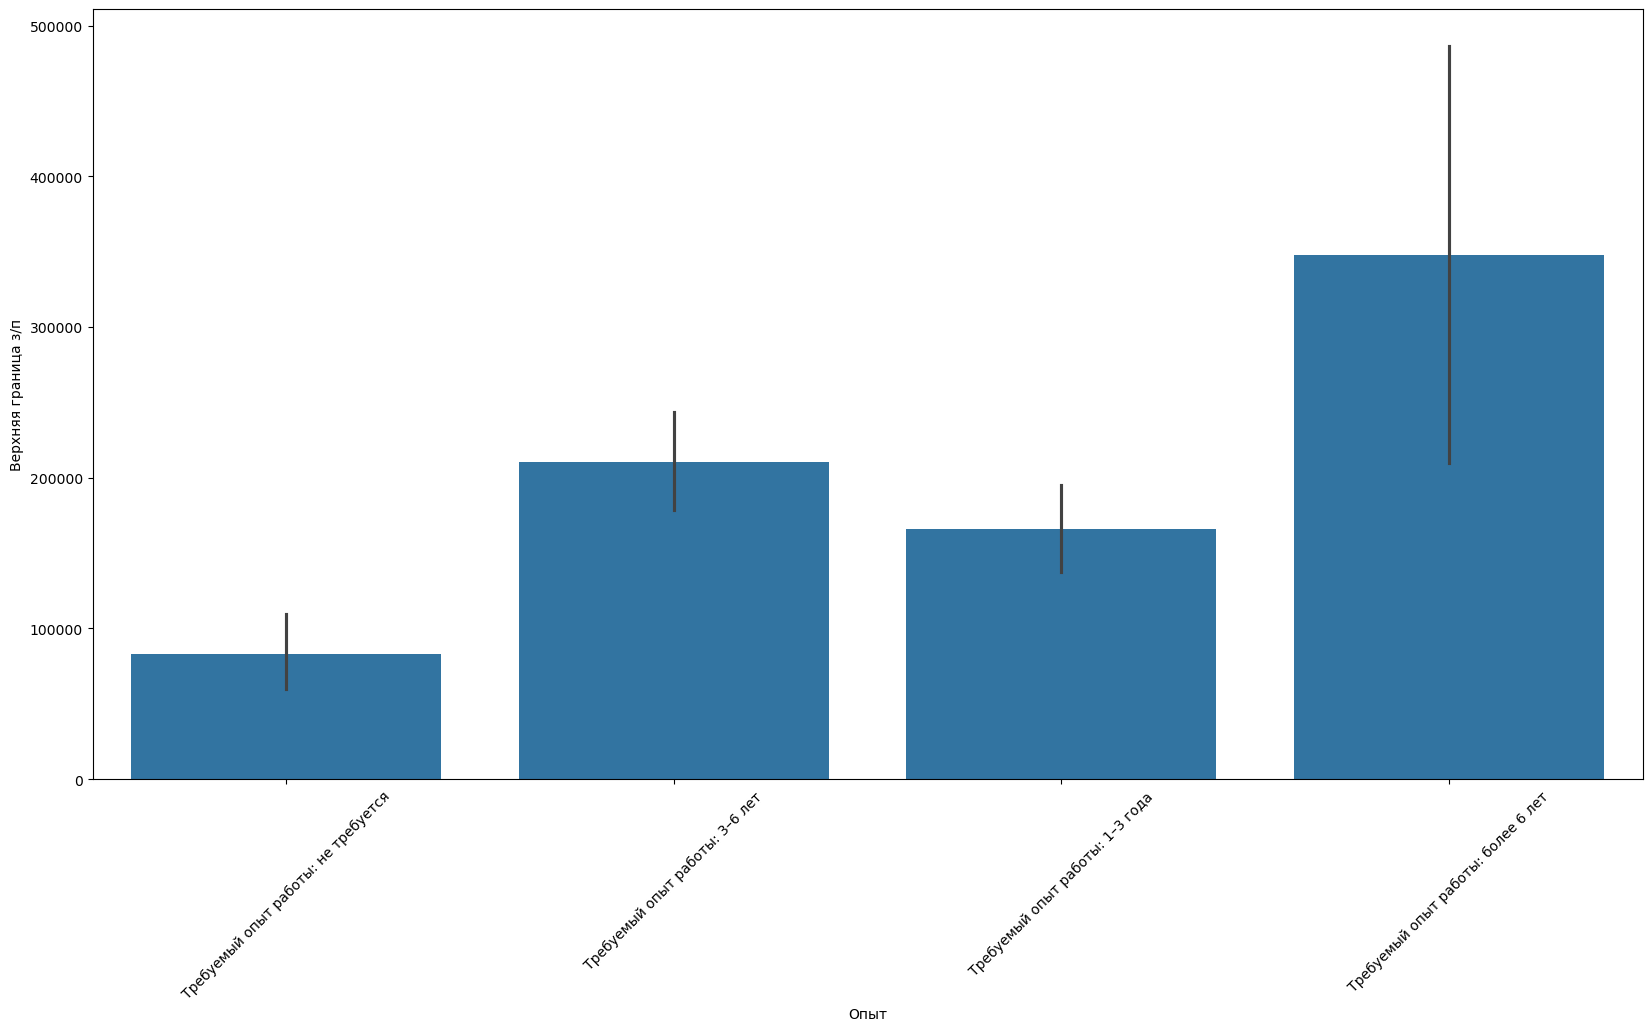

In [68]:
plt.figure(figsize=(20,10))
sns.barplot(x=df['experience'], y=df['upper_salary'])
plt.xticks(rotation=45) 

plt.xlabel('Опыт')
plt.ylabel('Верхняя граница з/п')
plt.show()

## Вывод: 

1) Самыми популярными навыками для всех вакансий без опыта являются: английский, грамотная речь, python, sql, Big Data. Следовательно можно сказать, что если вы хотите войти в IT, то для того чтобы быть мобильным, то нужно развивать самые популярные навыки.

3) Про з/п: нижняя модальная вилка з/п для специалистов без опыта - 60 к / 55 к (2 моды), верхняя модальная вилка з/п для специалистов без опыта - 55к, также посмотря на распределение можно сказать, что в целом нижняя вилка и верхняя у специалистов без опыта примерно равна.

   
5) Оценив распределения вилок, кол-ва вакансий взависимости от опыта можно заметить тенденцию, что чем больше опыт у человека, тем он востребованней. 
